The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

ret =  True


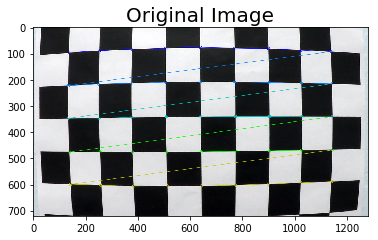

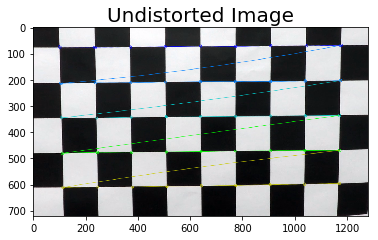

(<matplotlib.image.AxesImage at 0x116b8cb38>,
 None)

In [113]:
# Camera Calibration and Distortion Correction 
# The images for camera calibration are stored in the folder called camera_cal

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')

# Initialize object points and image points arrays
nx = 9
ny = 5
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
objpoints = []
imgpoints = []

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
print('ret = ',ret)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    objpoints.append(objp)
    imgpoints.append(corners)
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
# Input: image, object points, and image points
# Perform camera calibration, image distortion correction and 
# return the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Calibrate
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Run calibration and undistortion
undistorted = cal_undistort(img, objpoints, imgpoints)

plt.imshow(img), plt.title('Original Image', fontsize=20), plt.show()
plt.imshow(undistorted), plt.title('Undistorted Image', fontsize=20), plt.show()

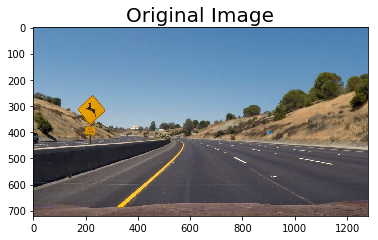

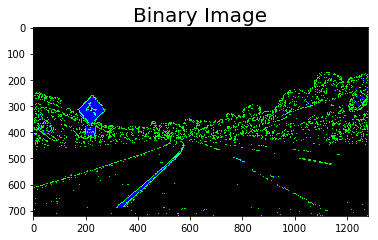

In [114]:
# Thresholding using color and gradient

# Load image
image = mpimg.imread('test_images/test2.jpg')

# Threshold function
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
thresh_image = pipeline(image)

#Plot the result
plt.imshow(image), plt.title('Original Image', fontsize=20)
plt.show()
plt.imshow(thresh_image), plt.title('Binary Image', fontsize=20)
plt.show()



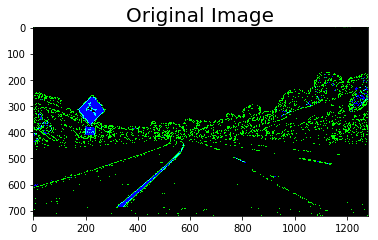

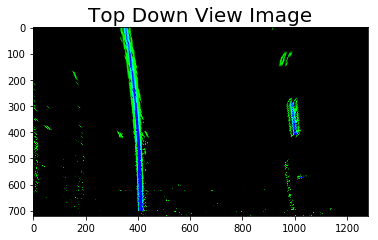

In [126]:
# Perspective Transform

# Read in an image
#img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = thresh_image

# Source and destination points
src = np.float32([[(200, 720), (565, 470), (725, 470), (1130, 720)]])
dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])

# Find perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst) 

# Image size
img_size = (img.shape[1], img.shape[0])

# Warp to top-down view 
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(img), plt.title('Original Image', fontsize=20)
plt.show()
plt.imshow(warped), plt.title('Top Down View Image', fontsize=20)
plt.show()